In [ ]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 144487 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.22-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.22-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.22-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [ ]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [ ]:
import os
os.chdir("/content/drive/titanic")
!pwd

/content/drive/titanic


In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import lightgbm as lgb
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import re
warnings.filterwarnings("ignore")

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
test_index = test.PassengerId.copy()
train.drop(["PassengerId"], axis = 1, inplace = True) # Drop
test.drop(["PassengerId"], axis = 1, inplace = True) # Drop

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
def eda_object(df,feature):
    a = len(df[feature].unique())
    plt.figure(figsize = [15,min(max(8,a),5)])

    plt.subplot(1,2,1)
    x_ = df.groupby([feature])[feature].count()
    x_.plot(kind='pie')
    plt.title(feature)

    plt.subplot(1,2,2)
    cross_tab = pd.crosstab(df['Survived'],df[feature],normalize=0).reset_index()
    x_ = cross_tab.melt(id_vars=['Survived'])
    x_['value'] = x_['value']

    sns.barplot(x=feature,y='value',hue ='Survived',data=x_,palette = ['b','r','g'],alpha =0.7)
    plt.xticks(rotation='vertical')
    plt.title(feature + " - Survived")

    plt.tight_layout()
    plt.legend()
    plt.show()

rm_list = ['PassengerId','Name','Ticket', "Cabin"]
type_list = ['object']
feature_list = []

for feature in train.columns:
    if (feature not in rm_list) & (train[feature].dtypes in type_list):
        feature_list.append(feature)

In [ ]:
train[["Survived", "Pclass", "Sex", "Cabin", "Embarked"]] = train[["Survived", "Pclass", "Sex", "Cabin", "Embarked"]].astype("object")

test[["Pclass", "Sex", "Cabin", "Embarked"]] = test[["Pclass", "Sex", "Cabin", "Embarked"]].astype("object")

In [ ]:
def eda_numeric(df,feature):
    x_ = df[feature]
    y_ = df['Survived']
    data = pd.concat([x_,y_],1)
    plt.figure(figsize=[15,5])

    ax1 = plt.subplot(1,2,1)
    sns.boxplot(x='Survived',y=feature,data=data)
    plt.title(feature+ " - Boxplot")
    upper_0 = data[data['Survived']==0][feature].quantile(q=0.75)
    upper_1 = data[data['Survived']==1][feature].quantile(q=0.75)
    lower_0 = data[data['Survived']==0][feature].quantile(q=0.25)
    lower_1 = data[data['Survived']==1][feature].quantile(q=0.25)

    ax1.set(ylim=(min(lower_0,lower_1),max(upper_0,upper_1)))

    ax2 = plt.subplot(1,2,2)
    plt.title(feature+ " - Density with Log")
    
    p1=sns.kdeplot(data[data['Survived']==0][feature].apply(np.log), color="b",legend=False)
    p2=sns.kdeplot(data[data['Survived']==1][feature].apply(np.log), color="r",legend=False)
    plt.legend(loc='upper right', labels=['0', '1'])

    plt.tight_layout()
    plt.show()
    
rm_list = ['PassengerId','Name','Ticket', "Cabin"]
type_list = ['int64','float']
feature_list = []

for feature in train.columns:
    if (feature not in rm_list) & (train[feature].dtypes in type_list) & (len(train[feature].unique()) > 5):
        feature_list.append(feature)

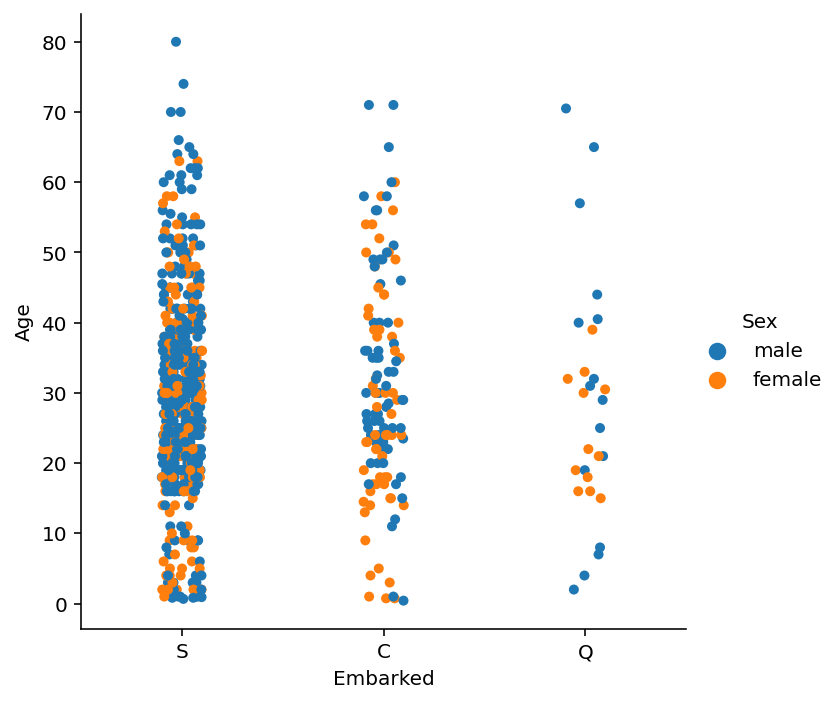

In [ ]:
%config InlineBackend.figure_format = "retina"
sns.catplot(x="Embarked", y="Age", data = train, hue = "Sex");

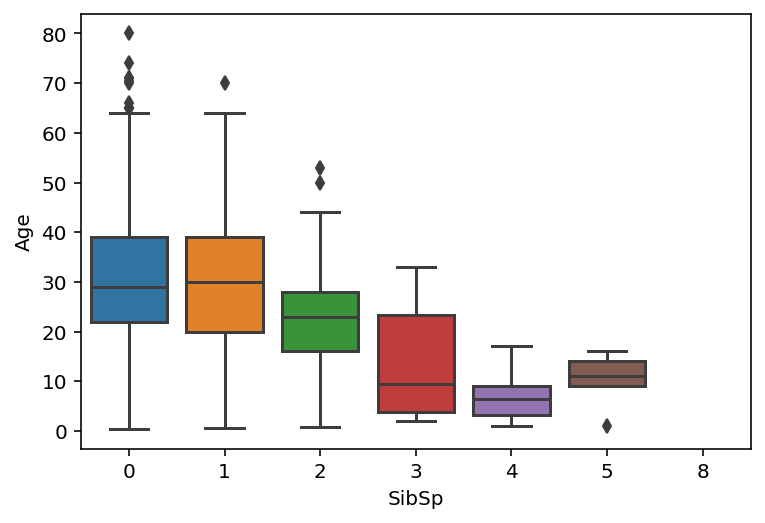

In [ ]:
sns.boxplot("SibSp", "Age", data = train);

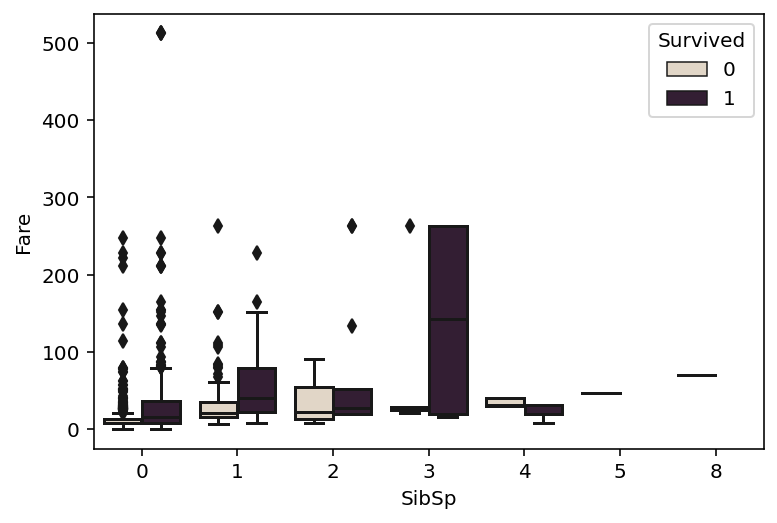

In [ ]:
sns.boxplot("SibSp", "Fare", hue = "Survived", data = train, palette="ch:0.25");

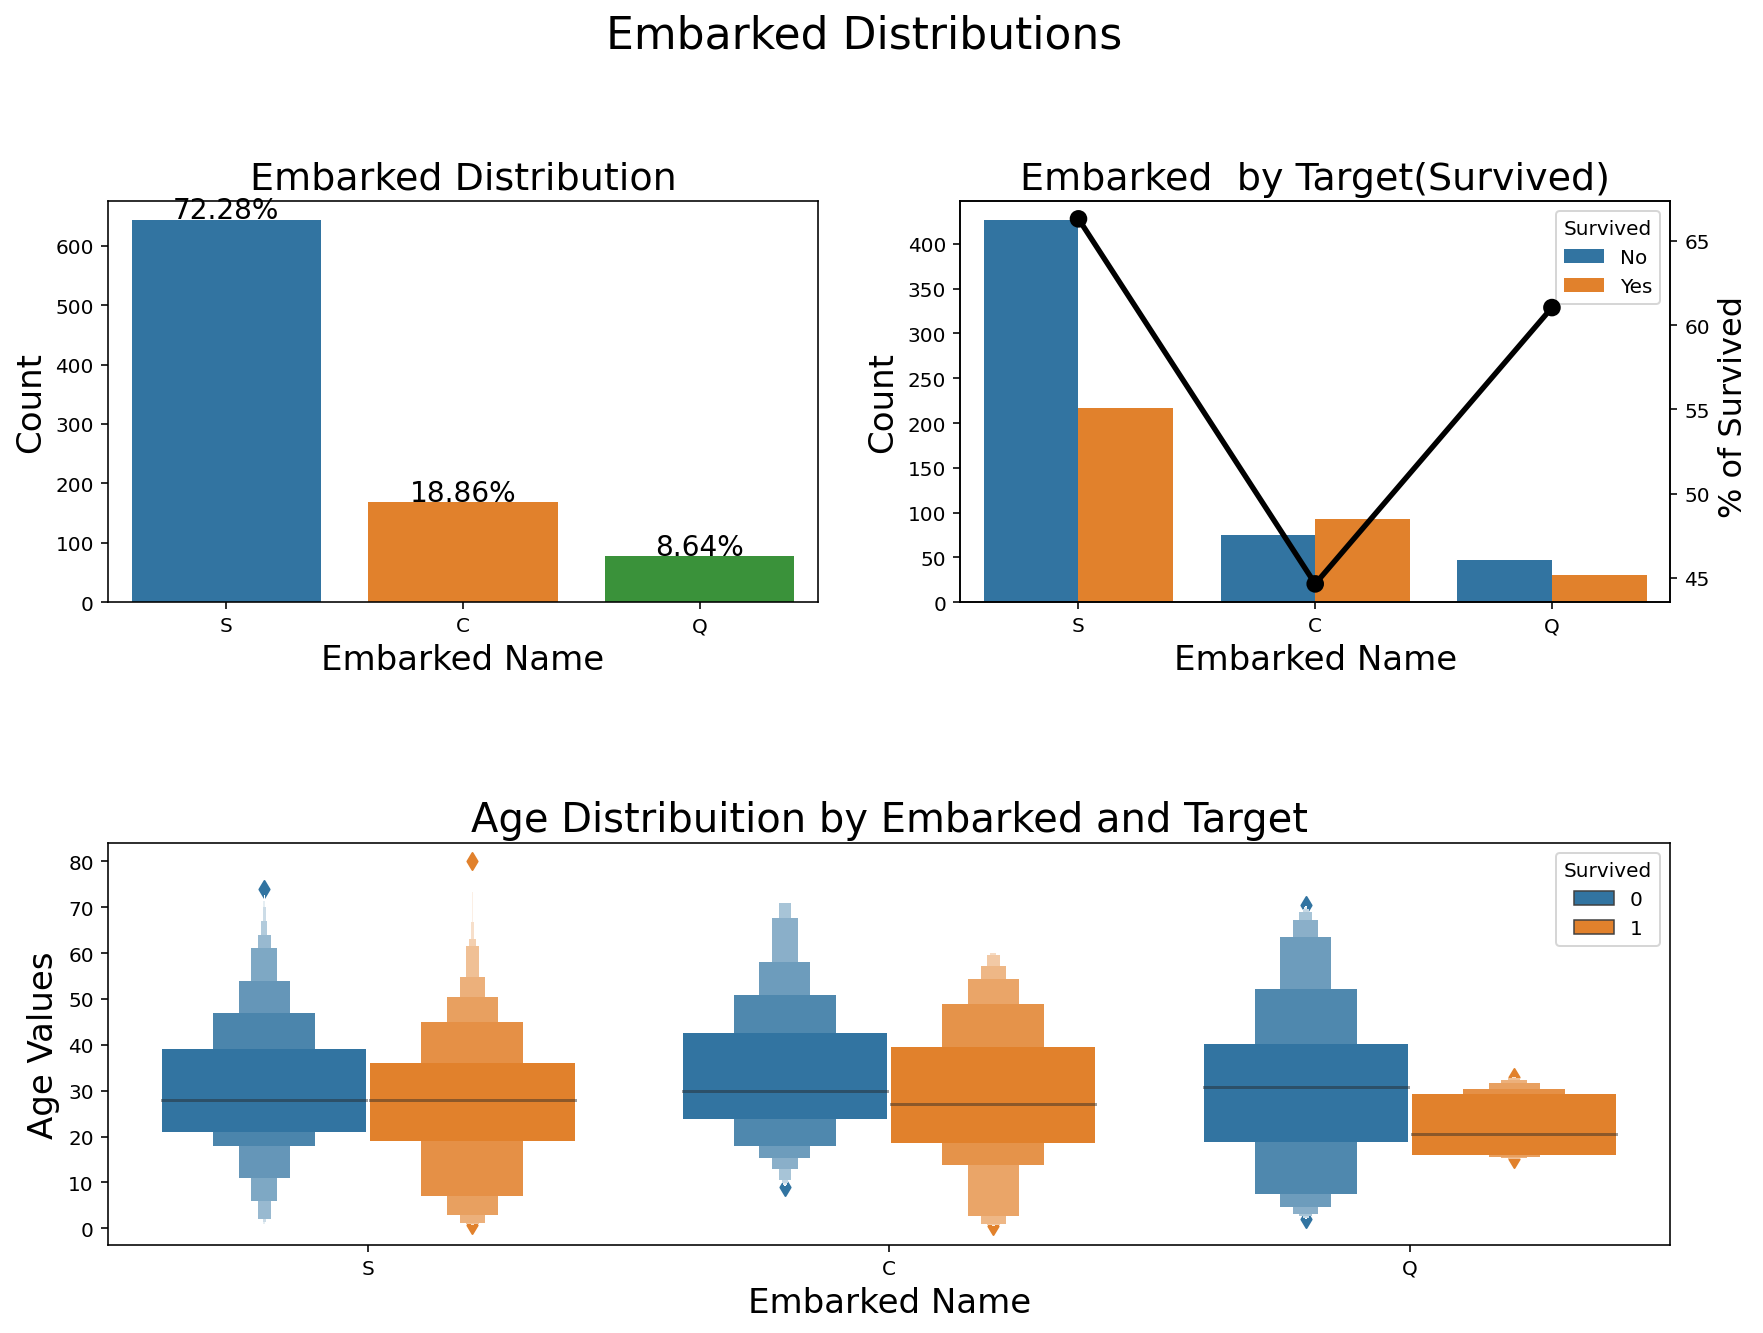

In [ ]:
tmp = pd.crosstab(train['Embarked'], train['Survived'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'Survived', 1:'NoSurvived'}, inplace=True)

plt.figure(figsize=(14,10))
plt.suptitle('Embarked Distributions', fontsize=22)

plt.subplot(221)
g = sns.countplot(x='Embarked', data=train)

g.set_title("Embarked Distribution", fontsize=19)
g.set_xlabel("Embarked Name", fontsize=17)
g.set_ylabel("Count", fontsize=17)

for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/len(train)*100),
            ha="center", fontsize=14) 

plt.subplot(222)
g1 = sns.countplot(x='Embarked', hue='Survived', data=train)
plt.legend(title='Survived', loc='best', labels=['No', 'Yes'])
gt = g1.twinx()
gt = sns.pointplot(x='Embarked', y='Survived', data=tmp, color='black', order=['S', 'C', 'Q'], legend=False)
gt.set_ylabel("% of Survived ", fontsize=16)

g1.set_title("Embarked  by Target(Survived)", fontsize=19)
g1.set_xlabel("Embarked Name", fontsize=17)
g1.set_ylabel("Count", fontsize=17)

plt.subplot(212)
g3 = sns.boxenplot(x='Embarked', y='Age', hue='Survived', 
              data=train[train['Age'] <= 100] )
g3.set_title("Age Distribuition by Embarked and Target", fontsize=20)
g3.set_xlabel("Embarked Name", fontsize=17)
g3.set_ylabel("Age Values", fontsize=17)

plt.subplots_adjust(hspace = 0.6, top = 0.85)

plt.show()

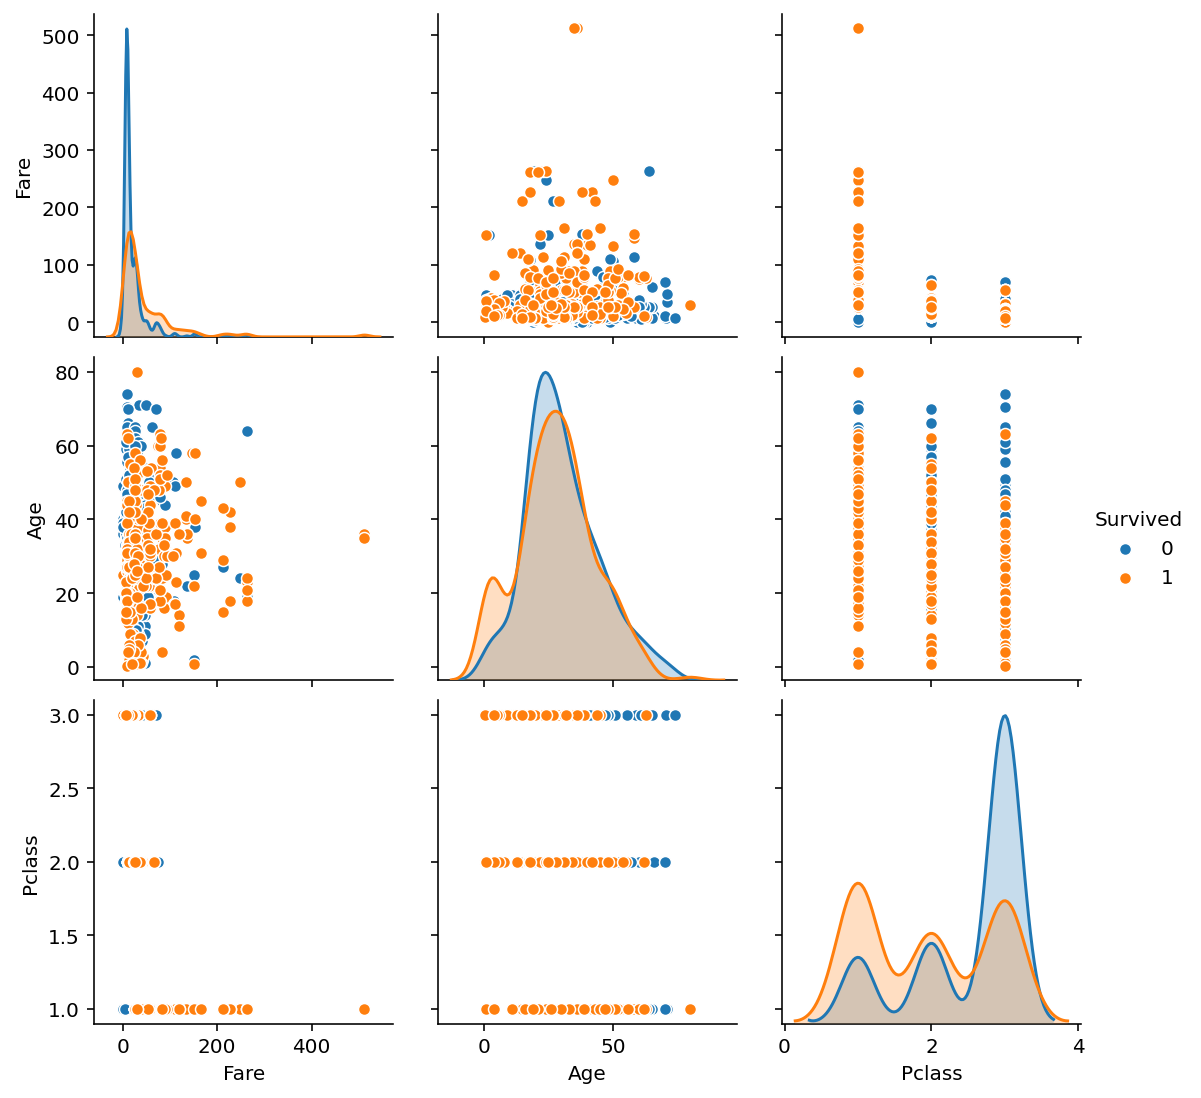

In [ ]:
sns.pairplot(data=train[["Fare", "Survived", "Age", "Pclass"]], hue = "Survived", dropna = True);

In [ ]:
pd.crosstab([train.Embarked, train.Pclass], [train.Sex, train.Survived], margins = True).style.background_gradient(cmap = 'cubehelix_r')

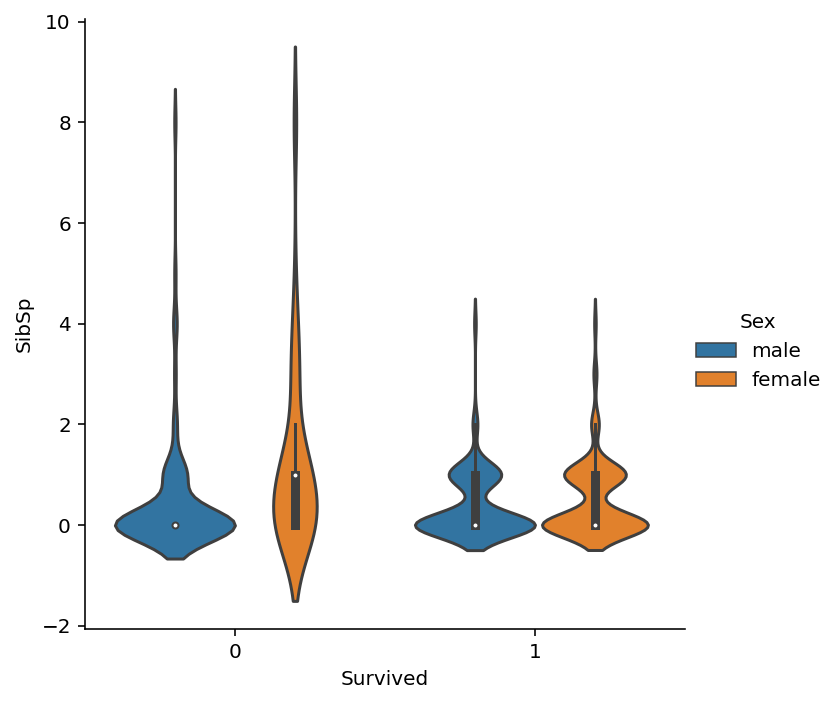

In [ ]:
sns.catplot("Survived", "SibSp", kind = "violin", hue = "Sex", data = train);

In [ ]:
def missing_zero_values_table(df):
    zero_val = (df == 0.00).astype(int).sum(axis=0)
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
    mz_table = mz_table.rename(
    columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
    mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
   mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
   mz_table['Data Type'] = df.dtypes
   mz_table = mz_table[
       mz_table.iloc[:,1] != 0].sort_values(
       '% of Total Values', ascending=False).round(1)
       print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
       "There are " + str(mz_table.shape[0]) +
        " columns that have missing values.")
   return mz_table
missing_zero_values_table(train)

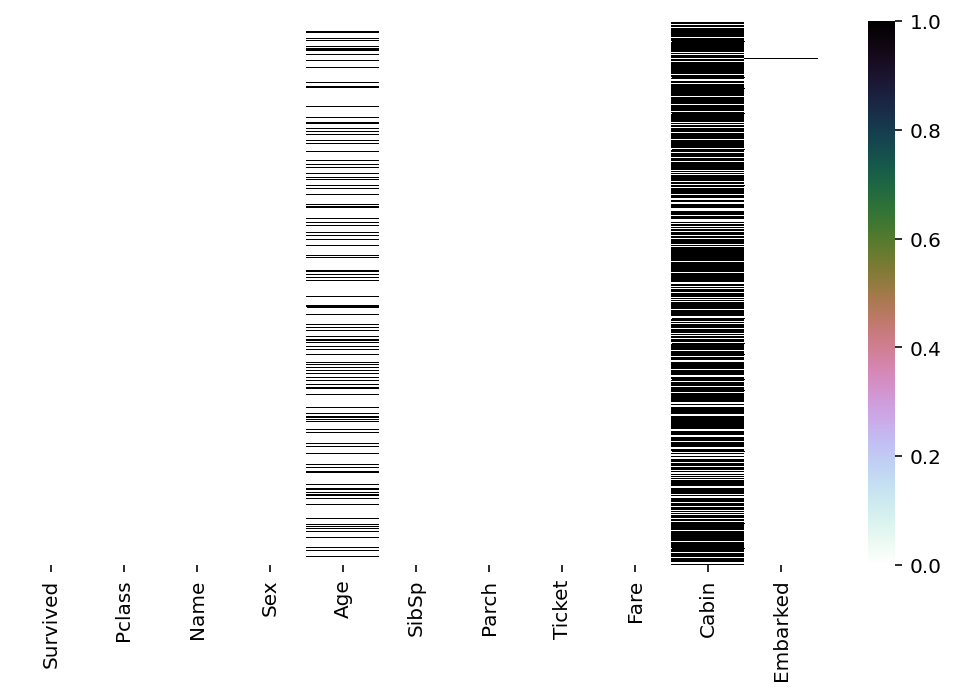

In [ ]:
fig, ax = plt.subplots(figsize = (9, 5))
sns.heatmap(train.isnull(), cmap = "cubehelix_r", yticklabels='')
plt.show()

In [ ]:
train["Embarked"] = train["Embarked"].fillna('S')
test["Embarked"] = test["Embarked"].fillna('S')

data = [train, test]

for dataset in data:
    mean = train["Age"].mean()
    std = test["Age"].std()
    is_null = dataset["Age"].isnull().sum()
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice
    dataset["Age"] = train["Age"].astype(int)
    
train["Fare"] = train["Fare"].fillna(train["Fare"].median())
test["Fare"] = test["Fare"].fillna(test["Fare"].median())

In [ ]:
%%time

train.Cabin.fillna("Miss", inplace=True)
train.Cabin = [i[0] for i in train.Cabin.astype("str")]



test.Cabin.fillna("Miss", inplace=True)
test.Cabin = [i[0] for i in test.Cabin.astype("str")]



train.Ticket = [i[0] for i in train.Ticket.astype("str")]
test.Ticket = [i[0] for i in test.Ticket.astype("str")]



# Fare değişkenini kategorikleştirelim (gruplayalım)


train.Fare_group = pd.DataFrame()
train['Fare_group'] = np.where(train['Fare'] < 7, 'Low_Fare',
   np.where(train["Fare"] < 14, "low_mid_Fare",
      np.where(train["Fare"] < 21, "mid_fare", 
     np.where(train["Fare"] < 28, "mid_high_fare", 
     np.where(train["Fare"] < 35, "high_low_fare",
       np.where(train["Fare"] < 42, "high_mid_fare",
          np.where(train["Fare"] < 49, "high_high_fare",
     np.where(train["Fare"] < 56, "top_fare",
   np.where(train["Fare"] < 63, "max_fare", "out_top_fare")))))))))


# Aynı işlemleri test verisine de uygulayalım
test.Fare_group = pd.DataFrame()
test['Fare_group'] = np.where(test['Fare'] < 7, 'Low_Fare',
                              np.where(test["Fare"] < 14, "low_mid_Fare",
                                      np.where(test["Fare"] < 21, "mid_fare", 
                                              np.where(test["Fare"] < 28, "mid_high_fare", 
                                                      np.where(test["Fare"] < 35, "high_low_fare",
                                                              np.where(test["Fare"] < 42, "high_mid_fare",
                                                                      np.where(test["Fare"] < 49, "high_high_fare",
                                                                              np.where(test["Fare"] < 56, "top_fare",
                                                                                      np.where(test["Fare"] < 63, "max_fare", "out_top_fare")))))))))

# Age değişkenini gruplayalım
train['Age_group'] = 0
train.loc[train['Age']  <= 15, 'Age_group'] = 0
train.loc[(train['Age'] > 15) & (train['Age'] <= 30), 'Age_group']=1
train.loc[(train['Age'] > 30) & (train['Age'] <= 45), 'Age_group']=2
train.loc[(train['Age'] > 45) & (train['Age'] <= 60), 'Age_group']=3
train.loc[train['Age']  > 60, 'Age_group'] = 4


test['Age_group'] = 0
test.loc[test['Age']  <= 15, 'Age_group'] = 0
test.loc[(test['Age'] > 15) & (test['Age'] <= 30), 'Age_group']=1
test.loc[(test['Age'] > 30) & (test['Age'] <= 45), 'Age_group']=2
test.loc[(test['Age'] > 45) & (test['Age'] <= 60), 'Age_group']=3
test.loc[test['Age']  > 60, 'Age_group'] = 4


train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
test['FamilySize'] = test['SibSp'] + test['Parch'] + 1

train.Alone = pd.DataFrame()
test.Alone = pd.DataFrame()

train["Alone"] = np.where(train["FamilySize"] < 2, 1, 0)
test["Alone"] = np.where(test["FamilySize"] < 2, 1, 0)

# Name değişkeninden kişinin ünvanını çıakrtalım
def title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name) 
    if title_search:
        return title_search.group(1)
    return ""

train['Title'] = train['Name'].apply(title)
test['Title'] = test['Name'].apply(title)

train['Title'] = train['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
train['Title'] = train['Title'].replace('Mlle', 'Miss')
train['Title'] = train['Title'].replace('Ms', 'Miss')
train['Title'] = train['Title'].replace('Mme', 'Mrs')

test['Title'] = test['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
test['Title'] = test['Title'].replace('Mlle', 'Miss')
test['Title'] = test['Title'].replace('Ms', 'Miss')
test['Title'] = test['Title'].replace('Mme', 'Mrs')

train['Fare_Per_Person'] = train['Fare']/(train['FamilySize'])
test['Fare_Per_Person'] = test['Fare']/(test['FamilySize'])

train.drop(["Name"], axis = 1, inplace = True)
test.drop(["Name"], axis = 1, inplace = True)

# Cabin ile Ticket değişkenini "_" ile birleştirelim

train["Cabin_Ticket"] = train["Cabin"]+"_"+train["Ticket"]
test["Cabin_Ticket"] = test["Cabin"]+"_"+test["Ticket"]

train['Cabin_Ticket_number'] = train['Cabin_Ticket'].apply(lambda x: len(x))
train['Title_grup_count'] = train.groupby(['Cabin_Ticket', 'Title'])['Cabin_Ticket_number'].transform('count')

# Kategorik ile numerik verileri gruplayarak yeni değişken üretelim

test['Cabin_Ticket_number'] = test['Cabin_Ticket'].apply(lambda x: len(x))
test['Title_grup_count'] = test.groupby(['Cabin_Ticket', 'Title'])['Cabin_Ticket_number'].transform('count')

train['Pclass_Alone_count'] = train.groupby(['Pclass', 'Alone'])['Age'].transform('count')
test['Pclass_Alone_count'] = test.groupby(['Pclass', 'Alone'])['Age'].transform('count')

train['Pclass_Alone_mean'] = train.groupby(['Pclass', 'Alone'])['Age'].transform('mean')
test['Pclass_Alone_mean'] = test.groupby(['Pclass', 'Alone'])['Age'].transform('mean')

train['Pclass_Alone_SibSp_count'] = train.groupby(['Pclass', 'Alone'])['SibSp'].transform('count')
test['Pclass_Alone_SibSp_count'] = test.groupby(['Pclass', 'Alone'])['SibSp'].transform('count')

train['Pclass_Alone_SibSp_mean'] = train.groupby(['Pclass', 'Alone'])['SibSp'].transform('mean')
test['Pclass_Alone_SibSp_mean'] = test.groupby(['Pclass', 'Alone'])['SibSp'].transform('mean')

train['Fare_group_Cabin_Age_count'] = train.groupby(['Fare_group', 'Cabin'])['Age'].transform('count')
test['Fare_group_Cabin_Age_count'] = test.groupby(['Fare_group', 'Cabin'])['Age'].transform('count')

train['Fare_group_Cabin_Age_mean'] = train.groupby(['Fare_group', 'Cabin'])['Age'].transform('mean')
test['Fare_group_Cabin_Age_mean'] = test.groupby(['Fare_group', 'Cabin'])['Age'].transform('mean')

train['Fare_group_Cabin_Fare_Per_Person_mean'] = train.groupby(['Fare_group', 'Cabin'])['Fare_Per_Person'].transform('mean')
test['Fare_group_Cabin_Fare_Per_Person_mean'] = test.groupby(['Fare_group', 'Cabin'])['Fare_Per_Person'].transform('mean')

train['Fare_group_Cabin_Fare_Per_Person_count'] = train.groupby(['Fare_group', 'Cabin'])['Fare_Per_Person'].transform('count')
test['Fare_group_Cabin_Fare_Per_Person_count'] = test.groupby(['Fare_group', 'Cabin'])['Fare_Per_Person'].transform('count')

train['Cabin_Ticket_Alone_count'] = train.groupby(['Cabin_Ticket', 'Alone'])['Age'].transform('count')
test['Cabin_Ticket_Alone_count'] = test.groupby(['Cabin_Ticket', 'Alone'])['Age'].transform('count')

train['Cabin_Ticket_Alone_mean'] = train.groupby(['Cabin_Ticket', 'Alone'])['Age'].transform('mean')
test['Cabin_Ticket_Alone_mean'] = test.groupby(['Cabin_Ticket', 'Alone'])['Age'].transform('mean')

train['Title_FamilySize_count'] = train.groupby(['Title', 'FamilySize'])['Fare'].transform('count')
test['Title_FamilySize_count'] = test.groupby(['Title', 'FamilySize'])['Fare'].transform('count')

train['Title_FamilySize_Parch_count'] = train.groupby(['Title', 'FamilySize'])['Parch'].transform('count')
test['Title_FamilySize_Parch_count'] = test.groupby(['Title', 'FamilySize'])['Parch'].transform('count')

train['Title_FamilySize_mean'] = train.groupby(['Title', 'FamilySize'])['Fare'].transform('mean')
test['Title_FamilySize_mean'] = test.groupby(['Title', 'FamilySize'])['Fare'].transform('mean')

train['Title_FamilySize_Parch_mean'] = train.groupby(['Title', 'FamilySize'])['Parch'].transform('mean')
test['Title_FamilySize_Parch_mean'] = test.groupby(['Title', 'FamilySize'])['Parch'].transform('mean')


# For döngüsü ile yeni parametreler 

columns=['Title_FamilySize_Parch_mean','Fare_group_Cabin_Age_mean', 'Age', 'Parch', 'SibSp', 'Title_FamilySize_mean', 'FamilySize', 'Fare_Per_Person', 'Fare_group_Cabin_Age_mean',
         'Cabin_Ticket_number', 'Fare_group_Cabin_Fare_Per_Person_count','Fare','Title_grup_count','Pclass_Alone_mean','Pclass_Alone_SibSp_count','Cabin_Ticket_Alone_mean','Title_FamilySize_count','Fare_group_Cabin_Fare_Per_Person_mean']


obj_cols=['Alone','Cabin_Ticket','Title', 'Fare_group','Cabin','Pclass','Age_group', "Embarked", "Sex"]


for col in columns:
    for feat in obj_cols:
        train[f'{col}_mean_group_{feat}']=train[col]/train.groupby(feat)[col].transform('mean')
        train[f'{col}_max_group_{feat}']=train[col]/train.groupby(feat)[col].transform('max')
        train[f'{col}_min_group_{feat}']=train[col]/train.groupby(feat)[col].transform('min')
        train[f'{col}_skew_group_{feat}']=train[col]/train.groupby(feat)[col].transform('skew')
        train[f'{col}_skew_group_{feat}']=train[col]/train.groupby(feat)[col].transform('count')
        
        
        
for col in columns:
    for feat in obj_cols:
        test[f'{col}_mean_group_{feat}']=test[col]/test.groupby(feat)[col].transform('mean')
        test[f'{col}_max_group_{feat}']=test[col]/test.groupby(feat)[col].transform('max')
        test[f'{col}_min_group_{feat}']=test[col]/test.groupby(feat)[col].transform('min')
        test[f'{col}_skew_group_{feat}']=test[col]/test.groupby(feat)[col].transform('skew')
        test[f'{col}_skew_group_{feat}']=test[col]/test.groupby(feat)[col].transform('count')

CPU times: user 5 s, sys: 55.8 ms, total: 5.06 s
Wall time: 5.07 s


In [ ]:
def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations !")
print(get_top_abs_correlations(train.select_dtypes(include=['int32','int64']), 30))

Top Absolute Correlations !
Title_FamilySize_count                  Title_FamilySize_Parch_count              1.000000
Pclass_Alone_count                      Pclass_Alone_SibSp_count                  1.000000
Fare_group_Cabin_Age_count              Fare_group_Cabin_Fare_Per_Person_count    1.000000
Age                                     Age_group                                 0.946354
SibSp                                   FamilySize                                0.890712
Title_grup_count                        Cabin_Ticket_Alone_count                  0.840369
Parch                                   FamilySize                                0.783111
Alone                                   Title_FamilySize_count                    0.780672
                                        Title_FamilySize_Parch_count              0.780672
FamilySize                              Alone                                     0.690922
Pclass_Alone_SibSp_count                Fare_group_Cabin_Age_c

In [ ]:
categorical_1 = ["Pclass", "Sex", "Ticket", "Cabin", "Embarked", "Fare_group", "Age_group", "Alone", "Title", "Cabin_Ticket"]

from sklearn.preprocessing import LabelEncoder
for col in train[categorical_1].columns:
        
    train[col] = train[col].astype(str)
    test[col] = test[col].astype(str)
        
    le = LabelEncoder()
    le.fit(list(train[col])+list(test[col]))
    train[col] = le.transform(train[col])
    test[col]  = le.transform(test[col])
        
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')

In [ ]:
y = train['Survived']
train = train.drop(['Survived'],axis=1)
nfolds = 15

folds = KFold(n_splits = nfolds, shuffle=True, random_state=4590)

# Hiperparametrelerimiz
params = {
    'num_leaves': 2**5 - 1,
    'max_depth': 8,
    'min_data_in_leaf': 50,
    'learning_rate': 0.05,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.75,
    'bagging_freq': 1,
    'metric': 'auc',
    'num_threads': 4,
    'verbose': -1,
    'objective': 'binary',
    'metric': 'auc',
    "boosting_type": "gbdt"
}

num_round = 10000

In [ ]:
feature_importance_df = np.zeros((train.shape[1], nfolds))
mvalid = np.zeros(len(train))
predictions  = np.zeros(len(test))


aucs = list()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, train.values)):
    print('----')
    print("fold n°{}".format(fold_))
    
    x0,y0 = train.iloc[trn_idx], y[trn_idx]
    x1,y1 = train.iloc[val_idx], y[val_idx]
    
    trn_data = lgb.Dataset(x0, label= y0); val_data = lgb.Dataset(x1, label= y1)
    
    clf = lgb.train(params, trn_data, 
                    num_round, valid_sets = [trn_data, val_data], 
                    verbose_eval=2000, 
                    early_stopping_rounds = 1000, 
                    categorical_feature = ["Pclass", "Sex", "Ticket", "Cabin", "Embarked", "Fare_group", "Age_group", "Alone", "Title", "Cabin_Ticket"])
    
    mvalid[val_idx] = clf.predict(x1, num_iteration=clf.best_iteration)
    
    feature_importance_df[:, fold_] = clf.feature_importance()
    
    predictions += clf.predict(test, num_iteration=clf.best_iteration) / folds.n_splits
    aucs.append(clf.best_score['valid_1']['auc'])
    
    
    
print('-' * 80)
print('-' * 70)
print('-' * 60)
print('-' * 50)
print('-' * 40)

print('Mean AUC:', np.mean(aucs).round(3))

----
fold n°0
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[769]	training's auc: 0.999988	valid_1's auc: 0.865212
----
fold n°1
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[53]	training's auc: 0.945392	valid_1's auc: 0.951389
----
fold n°2
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[481]	training's auc: 0.999838	valid_1's auc: 0.905093
----
fold n°3
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[84]	training's auc: 0.964822	valid_1's auc: 0.92832
----
fold n°4
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[23]	training's auc: 0.926847	valid_1's auc: 0.905502
----
fold n°5
Training until validation scores don't improve for 1000 rounds.
Early stopping, best iteration is:
[89]	training's auc: 0.966744	valid_1's auc: 0.9439

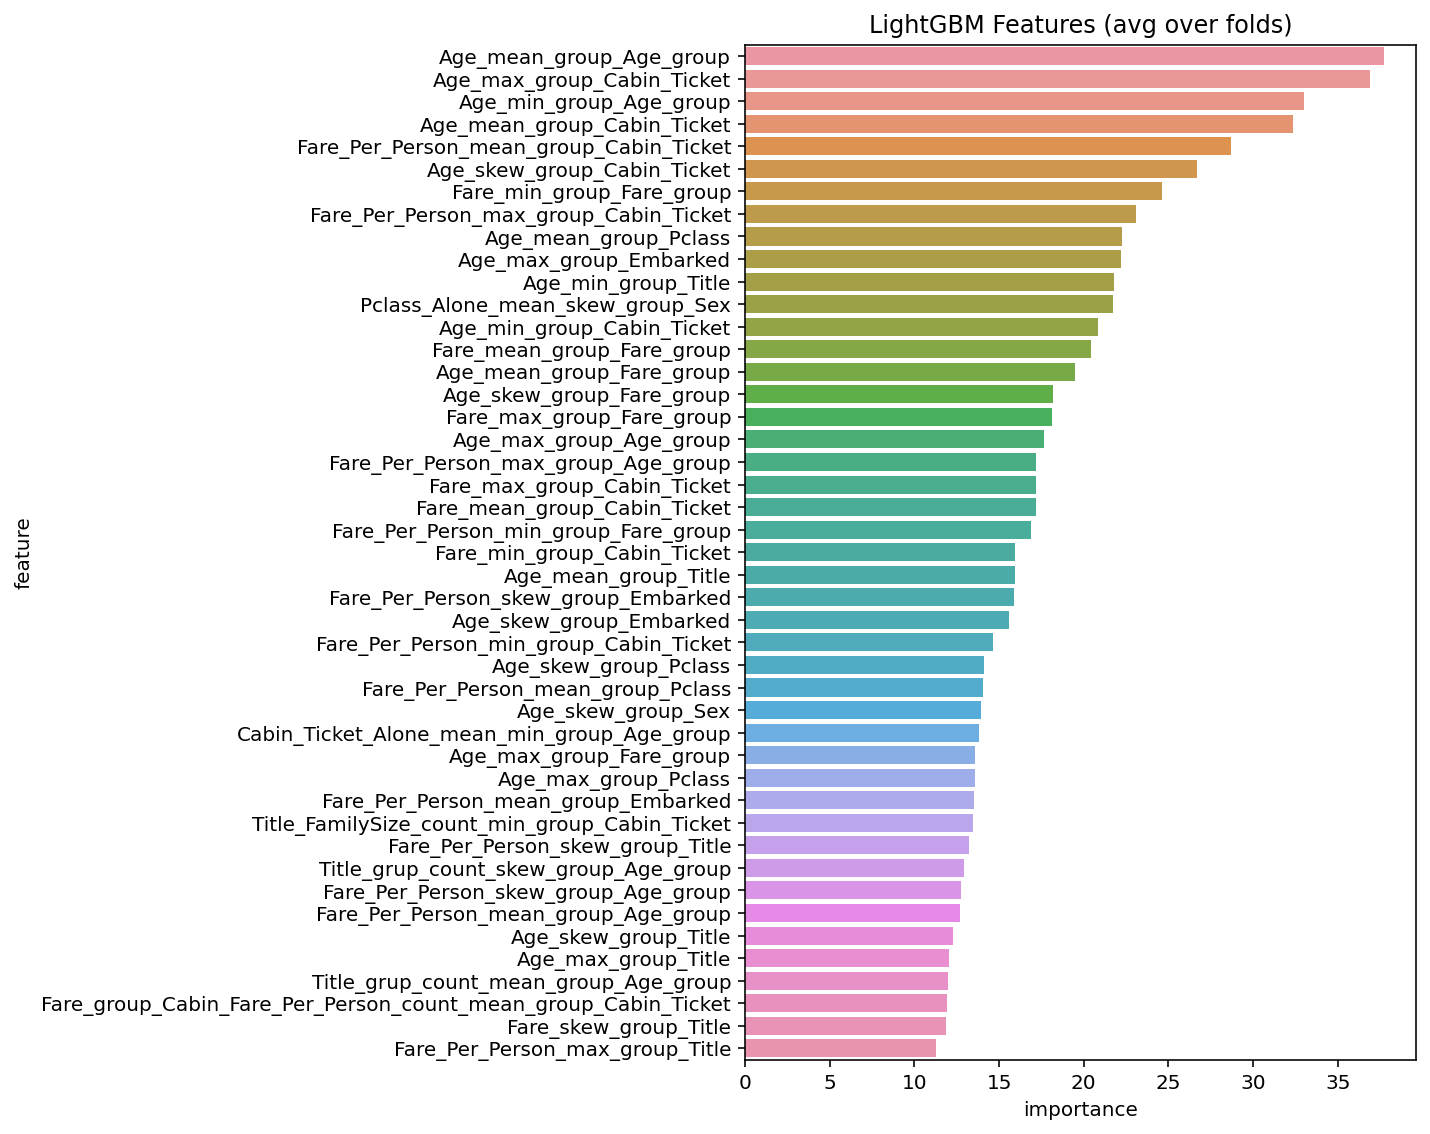

In [ ]:
ximp = pd.DataFrame()
ximp['feature'] = train.columns
ximp['importance'] = feature_importance_df.mean(axis = 1)

plt.figure(figsize=(10,8))
sns.barplot(x="importance",
            y="feature",
            data=ximp.sort_values(by="importance",
                                           ascending=False).head(45))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()